# Week 1 Lab: next generation sequencing and mutation hunting

## Part 1 (30 pts total)

**Due: Sunday 4/11/21 11:59pm**

Skills covered: basic UNIX navigation, intro to NGS, sequence alignment and variant calling, python plotting


### Intro
A patient arrives in your clinic with a rare disorder. You expect the condition is genetic (i.e. due to a mutation in her genome). However since the condition is not observed in any family members, you suspect it could be due to a *de novo* mutation that occurred in the germline (egg or sperm cells) of one of her parents.

To look for potential disease-causing mutations, you perform whole genome sequencing on the patient and her parents (which together we call a "trio").

This week, we will learn some key basics for processing next generation sequencing (NGS) data, including sequence alignment, variant calling, and standard file formats (FASTQ/BAM/VCF). For this week's assignment, many commands and template code are provided to you. In future labs, you'll be doing more of this set up on your own.

Today, we'll get familiar with the datasets and align our reads to the reference genome. In part 2, we'll dive deeper and go look for candidate mutations.

## 1. Inspect raw data manually

For this part, open up a separate window running a terminal where you can run the commands.

Before running any analysis, it's a good practice to look manually at the data to make sure all the files are what you think they are. First, you should look at the sequence files to verify the format is correct. You don’t want to open the entire files, you will just do a quick inspection of the first few reads. Use the `head` command to look at the first 20 lines in the first fastq file for the child genome (`NA12878_child_1.fq`). Replace [file.format] below with the actual path to this file. Recall from the exercises that the data files specific to this week's assignment can be found in the `/datasets/cs185-sp21-A00-public/week1` directory.

```shell
head -n 20 [file.format]
```

Take a look at each file. Each read has 4 lines of information, and then the next read starts on the
following line. The first line starts with the "@" symbol, and contains identifiers and information about
this read. The next line contains the actual sequence, then on line three there is a "+", which may
sometimes have the identifier and info repeated. 

Line 4 contains the quality string, where ASCII characters encode the quality score for each base.
The quality score ranges from 0 to about 40; the higher the number, the greater the confidence of the
base call. To get the actual quality score, you need to figure out the value of the symbol, then subtract
33 (this is called "Sanger" scaling type, because it's the same scaling that people use with traditional
sanger sequencing). With some older Illumina data (pre version 1.8), you subtract other numbers, like
64, for more info, see: 

http://drive5.com/usearch/manual/quality_score.html

Also take a look at the second file, containing the second read in each read pair. Notice the reads are in the same order in each file. e.g. the first reads in `NA12878_child_1.fq` and in `NA12878_child_2.fq` are paired. They have identical read identifiers, with the exception of the suffix `<read id>/1` vs. `<read id>/2`.

**Question 1 (3 pts)**: Look at the beginning of the `NA12878_child_1.fq` file, and find the third read. What is the read identifier? What is the quality symbol for the read's first base? Look up the value associated with this ASCII symbol online. What is the probability that this base is an error?

Set the variables `readid`, `qual`, and `p_error` to your answers below.

In [13]:
# Set the variables below to your answers
readid = 'HSQ1004:134:C0D8DACXX:1:1101:1529:183767/1'
qual = 'C' #67
p_error = 0.0004

# YOUR CODE HERE
#raise NotImplementedError()

In [9]:
# Make sure the answers are in the right format.
assert(len(readid)==42) # should be 42 characters long
assert(type(readid)==str) # should be a string type
assert(readid.startswith('HSQ')) # should start with 'HSQ'
assert(readid.endswith('/1')) # should end with '/`'
assert(readid.count(':')==6) # should have 6 colons in it

# Hidden tests check the actual answers

In [10]:
# Make sure the answers are in the right format.
assert(len(qual)==1) # should be 1 character
assert(qual in ''.join(chr(x) for x in range(128))) # should be a valid ascii characer

# Hidden tests check the actual answers

In [11]:
# Make sure the answers are in the right format.
assert(type(p_error)==float)
assert(p_error>0 and p_error<1)
assert(abs(10**(-1*(ord(qual)-33)/10)-p_error)<0.0001) # reported qual score should match reported p_error

# Hidden tests check the actual answers

AssertionError: 

Now let's take a look at the human reference genome, which is stored in `/datasets/cs185-sp21-A00-public/genomes/hg19.fa`, and introduce a new UNIX command. We can use the `cat` command to print the contents of a file to the screen. 

The reference genome is a pretty big file (~3GB GB) so we don't want to look at the whole thing at once. Instead, we'll use a UNIX trick of "piping" (using the `|` symbol) which allows us to take the output of one command and use it as input to the next:

```
cat hg19.fa | head -n 10
```

This command first ran `cat` to print the file to the screen (which we call "standard output"). Then the command of `head` used the output of `cat` as its input rather than specifying a file directly as we did above. We refer to this as "standard input".

<blockquote>
**UNIX TIP**: If you accidently open (e.g. cat) a huge file and just see characters flying down your screen, or if you think a process you are running may be stuck, you can press control+c to cancel the last command.
</blockquote>

We can string together a bunch of commands using pipes, which can be pretty flexible. e.g. if you want look further down the file at lines 9991 through 10,000 you can do:

```
cat hg19.fa | head -n 10000 | tail -n 10
```

which prints the reference genome, takes the top (`head`) 10,000 lines, then the last (`tail`) 10 lines of that.

**Question 2 (1 pt)**: What is the name of the first chromosome listed in the reference genome? Set the variable `first_chrom` to your answer below.

In [14]:
first_chrom = 'chr1' # Set to the name of the first chromosome

# YOUR CODE HERE
#raise NotImplementedError()

In [15]:
# Make sure the answer makes sense
assert(type(first_chrom)==str)
assert(len(first_chrom)==4)
assert("chr" in first_chrom)

# Hidden tests check the actual answer

**Question 3 (2 pts)**: Write a one-line UNIX command to print out the line containing the read ID of the 100th read (and nothing else) from the file `NA12878_child_1.fq`. (Hint: remember each read takes up 4 lines). 

Test your command in the terminal. Then paste the entire command into the variable `question3_cmd` below. The autograder tests will make sure your command runs and produces a reasonable output.

Note, if you see a message `cat: write error: Broken pipe`, you can ignore this. It is just a warning.

In [23]:
# Edit this command to print the line with the read ID of the 100th read.
# The provided command prints the the line with read ID of the 1st read.
# Use absolute path to make sure the command runs correctly from the notebook
question3_cmd = 'cat /datasets/cs185-sp21-A00-public/week1/NA12878_child_1.fq | head -n 397 | tail -n 1' 
#line 397 has 100'th ID, given that it starts at 1 and occurs every 4 lines

# YOUR CODE HERE
#raise NotImplementedError()

In [21]:
# Load librarie to run tests
from subprocess import Popen, PIPE
p = Popen(question3_cmd, shell=True, stdout=PIPE, stderr=PIPE)
out, err = p.communicate()

# Check that the command runs correctly
assert(p.returncode == 0)

# Check output
output = out.decode("utf-8") # convert stdout output to a string
assert(output.startswith("@HSQ"))
assert(output.strip().endswith("/1"))
assert(output.strip() != "@HSQ1004:134:C0D8DACXX:1:1101:1427:17913/1") # This is the result if the command is unedited

# Hidden tests check the actual answer

We'll introduce one more helpful UNIX command before moving on. The tool `wc` includes a helpful option to count the number of lines in a file:

```
wc -l [filename]
```

<blockquote>
If you want more details about a UNIX tool, you can try looking at the manual using `man`, e.g. `man wc`. Since our Jupyter Lab environment is running on a limited UNIX setup, `man` won't always work (unfortunately). But you can either type this into another terminal you have access to, or check out man pages online for most commands. e.g. https://linux.die.net/man/1/wc.
</blockquote>

**Question 4 (2 pts)**: Using `wc -l`, determine how many read pairs we have for each of the three samples (child, mother, and father). Set the variables `numpairs_child`, `numpairs_father`, and `numpairs_mother` below to your answers.

In [24]:
numpairs_child = 0
numpairs_father = 0
numpairs_mother = 0

# YOUR CODE HERE
nline_child = 208148
nline_father = 211088
nline_mother = 223596
numpairs_child = nline_child/4
numpairs_father = nline_father/4
numpairs_mother = nline_mother/4
#raise NotImplementedError()

In [25]:
# The below should pass if the numpairs were set corretly
assert(numpairs_child > 0 and numpairs_child < 100000)
assert((numpairs_child+numpairs_mother+numpairs_father) == 160708)

# Hidden tests check actual values

## 2.  Inspect raw sequencing data with fastqc

In the terminal, `cd` into your home directory. Make a new directory `week1` using the `mkdir` command (which just makes a new directory). Use `ls` to confirm the `week1` directory is there, and `cd` into it.

```
cd
mkdir week1
ls
cd week1
```

This is where you will be working for the rest of the week.

Now you are ready to run `fastqc`, a simple fastq statistics analysis program. First, make sure the program is working and properly installed by typing the command below. You should see the manual page. Please ask a TA if this is not working.

```
fastqc -h
```

Run the program fastqc on the fastq files. You will have to specify the path to the `/datasets/cs185-sp21-A00-public/week1/` folder, since you should leave the files there. You also have to use the `-o` argument to tell `fastqc` to output the files to the current directory, which you can indicate with a `.` The command to do all this is below, but you have to specify the full root path to each fastq file.

```
fastqc -o . NA12878_child_1.fq NA12878_child_2.fq NA12891_father_1.fq NA12891_father_2.fq NA12892_mother_1.fq NA12892_mother_2.fq
```

Check with `ls` that this generated some files. The html files contain the whole report. You can view them by going to the notebook view (https://datahub.ucsd.edu/user/yourusername/tree), navigating to your `week1` directory, and clicking on the files.

Open one of the files and take a look. Do the basic statistics match what you calculated for the number of reads? On the left, you’ll see a navigation window with green (normal), yellow (slightly abnormal), and red (very unusual) circles for several kinds of analyses. If you have any red circles, take note, and read the fastqc documentation on the analysis modules to try to learn what they mean.

http://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/

Our sequencing datasets are high quality and nothing should be flagged in red, indicating we're ready to move on to sequence alignment.

**Question 5 (2 pts)**: Look at the "Per base sequence quality" section of the `fastqc` output for one of the files. What happens to the quality scores as you get toward the end of the read? Propose an explanation for why. Set the variable `answer_q5` below to your answer.

Options:

A. Quality scores increase across the read. This is because the sequencer adjusts its base calling algorithm as it goes, so reads higher quality data at the end of reads.

B. Quality scores decrease across the read. This is because as you read more and more bases, the copies of the DNA in each cluster on the flow cell get out of sync, making the calls more uncertain.

C. Quality scores decrease across the read. This is because the DNA starts degrading during sequencing.

D. Both B and C are correct.

In [1]:
answer_q5 = 'C' # Set to A, B, C, or D

# YOUR CODE HERE
#raise NotImplementedError()

In [2]:
# Check that an answer is given
assert(answer_q5 in ['A','B','C','D'])

# Hidden tests check the actual answer

## 3. Aligning sequences to the reference genome

To make sense out of these small sequences of DNA, we will map them to our reference sequence. Mapping works by taking each read and trying to find the closest matching sequence in the reference genome. 

There are many alignment programs ("aligners") available. The earliest alignment algorithms (Smith Waterman and Needleman-Wunsch) are still used today to compare small pieces of DNA one-by-one, but the computing power needed to map millions of short reads to genomes that are millions to billions of basepairs long requires special algorithms to speed up the process.

Today we will use an aligner called BWA-MEM, which makes use of the Burrows-Wheeler transform for reversible data compression (the reference is summarized with a special reversible index, the index makes it faster to search). BWA-MEM is optimized for ‘long’ next-generation sequencing reads of 100bp or more, which may contain several mutations, insertions, or deletions, as it works by finding the ‘maximum exact match’ within a read to the reference, rather than forcing the entire read to match.

First we need to index the reference file. This step takes a while, so **it has already been done for you**. We created the BWA-MEM index by running:

```
bwa index hg19.fa # don't run this!
```

This created several index files the program uses to rapidly search the genome. Do:
```
ls /datasets/cs185-sp21-A00-public/genomes/hg19.fa*
```

to see a list of those index files. Notice the `*` in the command above. This is a wildcard. We are telling `ls` to list all files that start with `/datasets/cs185s-sp20-public/genomes/hg19.fa*`.

Now we're ready to perform the alignment. We'll first look at the usage message for the tool to see how to run it. Simply type the name of the command.

```
bwa mem
```

Note the line at the top that says: 
```
Usage: bwa mem [options] <idxbase> <in1.fq> [in2.fq]
```

This tells us what we need to run. The alignment command takes inputs in this order: first, specify the path to the fasta reference genome file used to create the index. Then specify the data files in fastq format. If the data is paired end, specify both of the fastq files. (Things in square brackets are optional.)

BWA MEM outputs alignments to standard output. We can use the `>` operator to redirect the output to a file. e.g.:

```
bwa mem [options] <idxbase> <file1.fq> <file2.fq> > output.sam
```

**Question 6 (9 pts)**: Based on the usage information above, align all three samples to the hg19 reference genome and output the alignments for each to a SAM file with names `NA12878_child.sam`, `NA12891_father.sam`, and `NA12892_mother.sam` in your home directory.

To check that the command ran successfully and created the correct output, we'll check the file size of the output sam file (in bytes). You can use:

```
ls -l NA12878_child.sam # should return 34554278
```

to get the size of the output file. 

(**Note:** we've found that small differences in bwa mem commands, e.g. using absolute vs. relative paths, can result in very small differences. Don't worry if you got a slightly different number for the above, like 34554276. The autograder allows some wiggle room).

Below, complete the following:

* Question 6.1 (3 pts): Set the variable `bwa_cmd` to the commands you used to run `bwa` on the three samples. You can put each command on a separate line.
* Question 6.2 (2 pts each, 6 pts total): Fill in the variables `size_child`, `size_father`, and `size_mother` to the file sizes for the files `NA12878_child.sam`, `NA12891_father.sam`, and `NA12892_mother.sam` respectively. (Note, the answer for the child is already given in the example above).

In [1]:
# Replace text below with the alignment commands you used
# This is an example of a multi-line Python string, denoted by triple quotes
bwa_cmd = """
bwa mem /datasets/cs185s-sp20-public/genomes/hg19.fa NA12878_child_1.fq NA12878_child_2.fq > NA12878_child.sam
bwa mem /datasets/cs185s-sp20-public/genomes/hg19.fa NA12891_father_1.fq NA12891_father_2.fq > NA12891_father.sam
bwa mem /datasets/cs185s-sp20-public/genomes/hg19.fa NA12892_mother_1.fq NA12892_mother_2.fq > NA12892_mother.sam
"""

# Set to file size of each sam file
size_child = 34554196
size_father = 34972091
size_mother = 37040858

# YOUR CODE HERE
#raise NotImplementedError()

In [2]:
# Test answers are reasonable
assert("bwa mem" in bwa_cmd)

# Hidden tests check actual values

In [3]:
assert(size_child > 34000000 and size_child < 35000000)
# Hidden tests check actual values

In [4]:
assert(size_father > 34000000 and size_father < 35000000)
# Hidden tests check actual values

In [5]:
assert(size_mother > 36000000 and size_mother < 40000000)
# Hidden tests check actual values

**Alignment may take a few minutes, in the mean time, read about "sam":** BWA outputs data in the "SAM" format. We'll explore the data below, but to learn more, check out: https://samtools.github.io/hts-specs/SAMv1.pdf

## 4. Meet SAM, inspect the alignment

Look at first five lines of the child alignment of your new sam file with head:

```shell
head -n 50 NA12878_child.sam
```

<blockquote>
**UNIX TIP**: If lines are really long, the above command will result in output that is hard to read in the terminal, since it will "wrap" the lines. You can pipe output to `less -S` to make things more readable, and to allow you to scroll horizontally.
</blockquote>

```shell
head -n 50 NA12878_child.sam | less -S # easier to read
```

The first chunk of lines beginning with `@` are part of the header. After that comes the actual alignments.

Not all reads will be successfully aligned to the reference. The SAM file contains all reads, whether they successfully aligned or not. It's important to know what fraction of your reads aligned. If there are a lot reads that failed to align, that could indicate that your DNA was contaminated with some other source, or that something went wrong with the alignment.

In the SAM format, each line (after the headers) starts with a unique read ID in the first "field". Fields are delimited (separated) regions of data, similar to columns on a spreadsheet. SAM files use tabs as the delimiters. In later classes we will get into what some of the different fields mean (you should be able to recognize the quality string and the base string).

For now we are going to use the built in utilities of `samtools`, a program designed to read and parse sam files, to decode the samfile for us. Run the commands below to get some basis statistics.

```
samtools flagstat NA12878_child.sam
samtools flagstat NA12891_father.sam
samtools flagstat NA12892_mother.sam
```

Does the "in total" match the read count you computed earlier? You'll notice a slight discrepancy. Some reads will have multiple mappings (listed as secondary or supplementary) and for a couple reads only one read in the pair could be mapped. But the numbers should be pretty close.

**Question 7 (2 pts)**: What percentage of reads are mapped for each sample? Set the variables `perc_aligned_child`, `perc_aligned_father`, and `perc_aligned_mother` below to your answers.

In [6]:
perc_aligned_child = 99.81 # this one is done for you
perc_aligned_father = 98.96
perc_aligned_mother = 99.09

# YOUR CODE HERE
#raise NotImplementedError()

In [7]:
assert(perc_aligned_child==99.81)
assert(perc_aligned_father > 0 and perc_aligned_father < 100 and round(perc_aligned_father, 2)==perc_aligned_father)
assert(perc_aligned_mother > 0 and perc_aligned_mother < 100 and round(perc_aligned_mother, 2)==perc_aligned_mother)

# Hidden tests check actual values

Next, you need to compress and sort the SAM files with the commands below. A compressed SAM file is called a BAM file. Like the reference, BAM files need to be indexed. This gets the data ready for some of the next commands we will use.

```
samtools view -S -b NA12878_child.sam > NA12878_child.bam
samtools sort NA12878_child.bam > NA12878_child.sorted.bam
samtools index NA12878_child.sorted.bam
```

The index command will generate a file `NA12878_child.sorted.bam.bai`. Use `ls` to check that it's there.

**Question 8 (6 pts)**: Using the above as a guide, generate sorted and indexed BAM files for each family member. Make sure to use the same file name conventions as we have used above. 

* Question 8.1 (3 pts): Paste the commands you used to convert to BAM, sort, and index the alignments for each family member in the variable `sort_index_cmd` below.
* Question 8.2 (1 pt each, 3 pts total): Use the `ls -l` command to get file sizes (in bytes) for the index files `NA12878_child.sorted.bam.bai`, `NA12891_father.sorted.bam.bai`, and `NA12892_mother.sorted.bam.bai`. Set the variables `size_child_index`, `size_father_index`, and `size_mother_index` below.

In [8]:
# Replace text below with the commands you used to sort and index your alignments for each sample.
# You will likely have more than 3 commands
sort_index_cmd = """
samtools view -S -b NA12878_child.sam > NA12878_child.bam
samtools sort NA12878_child.bam > NA12878_child.sorted.bam
samtools index NA12878_child.sorted.bam
samtools view -S -b NA12891_father.sam > NA12891_father.bam
samtools sort NA12891_father.bam > NA12891_father.sorted.bam
samtools index NA12891_father.sorted.bam
samtools view -S -b NA12892_mother.sam > NA12892_mother.bam
samtools sort NA12892_mother.bam > NA12892_mother.sorted.bam
samtools index NA12892_mother.sorted.bam
"""

# Set to file sizes of each index file
size_child_index = 1309616
size_father_index = 1210448
size_mother_index = 1227744

# YOUR CODE HERE
#raise NotImplementedError()

In [9]:
# Test answers are reasonable
assert("samtools" in sort_index_cmd)
assert("view" in sort_index_cmd)
assert("index" in sort_index_cmd)

# Hidden tests check actual values

In [10]:
assert(size_child_index > 1300000 and size_child_index < 1400000)
# Hidden tests check actual values

In [11]:
assert(size_father_index > 1200000 and size_father_index < 1400000)
# Hidden tests check actual values

In [12]:
assert(size_mother_index > 1200000 and size_mother_index < 1400000)
# Hidden tests check actual values

## 5. Inspecting the template length distribution 

It is a good idea to do some basic quality checks on our BAM file.

Since our data is paired end, reads should be aligned in pairs, where each pair of reads aligns pretty close to each other. The distance between paired reads allows us to infer the size of the fragment that was sequenced. Here we will inspect the distribution of fragment lengths in our data.

First, we'll introduce a new UNIX command, `cut`. This command can extract different columns from a text file. e.g.:

```
cut -f 3,5 file.txt
```

will extract the 3rd and 5th columns of a tab-delimited file.

If you look back to the SAM specification, you'll see the 9th column gives the observed template length. This will be equal to 0 for reads that are not properly paired.

**Question 9 (3 pts)**: For the child genome, write and execute a one line UNIX command to extract a list of template lengths from the region chr6:128405804-128605805 to a file named `child_template_lengths.txt`. Your command should not change the order of reads from their order in the BAM file.

* Question 9.1 (1 pt): Set the variable `tlen_cmd` below to the command you used. Make sure your command is only one line.
* Question 9.2 (2 pts): Look at the first 5 values in the file you output, `child_template_lengths.txt`. Replace the values in `tlen_first5` below with those values. 

Hints:
* A command of the format `samtools view file.bam chr:start-end` will print out all reads falling in a certain region. This only works on BAM files that are sorted and indexed.
* You can pipe together a `samtools view` and `cut` command and use `>` to direct output to a file.

Note the variable `tlen_first5` is an example of a Python list. To read more about Python lists, see here: https://www.w3schools.com/python/python_lists.asp

In [13]:
tlen_cmd = "samtools view NA12878_child.sorted.bam chr6:128405804-128605805 | cut -f 9 > child_template_lengths.txt" # Set to your one-liner command here
tlen_first5 = [304, 316, 256, 337, 221] # Set to the first 5 template lengths. The first 2 are done for you.

# YOUR CODE HERE
#raise NotImplementedError()

In [14]:
# Test the command is reasonable
assert("samtools" in tlen_cmd)
assert("view" in tlen_cmd)
assert(">" in tlen_cmd)


In [15]:
# Check the answer is in the right format
assert(type(tlen_first5)==list)
assert(tlen_first5[0]==304)
assert(tlen_first5[1]==316)
assert(len(tlen_first5)==5)
assert([int(item)==item for item in tlen_first5])

# Hidden tests check actual values

Finally, we'd like to visualize the distribution of template lengths. We can do this using python. This time, we have written the plotting code for you. Study the commands below. We will draw on this to make similar plots in future labs. We'll also talk more about plotting in class.

Note, the code below uses our precomputed results for `child_template_lengths.txt`. You can use this to check your answer for question 9 above.

Run the code in the cell below to generate a histogram of template lengths and compute the median and median template lengths after removing 0's (indicating improperly paired reads). 

**Challenge problem (no points)**: Modify the code below to also show the best fit normal distribution. You can find an example of how to do this here: https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data/20012350.

Populating the interactive namespace from numpy and matplotlib
Mean template length: 317
Median template length: 317


(317.0, 317.1514420281428)

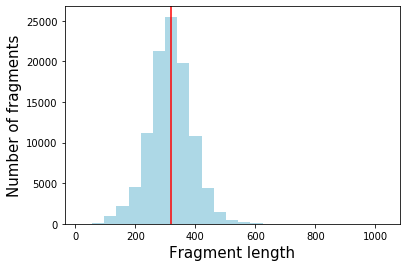

In [16]:
%pylab inline
import os
import numpy as np

def PlotTlenDist(plot=False):
    median_tlen = 0
    mean_tlen = 0
    
    # Read template lengths into a list
    tlens = open("/datasets/cs185-sp21-A00-public/week1/precomputed/child_template_lengths.txt").readlines()
    # Convert items in tlens list to integers
    tlens = [abs(int(item.strip())) for item in tlens]
    # Remove "0"
    tlens = [item for item in tlens if item > 0]
    
    # Compute median and mean of tlens below
    mean_tlen = np.mean(tlens)
    median_tlen = np.median(tlens)
    
    # Plot. See https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
    print("Mean template length: %d"%mean_tlen)
    print("Median template length: %d"%median_tlen)

    if plot:
        plt.hist(tlens, bins=25, color="lightblue")
        plt.xlabel("Fragment length", size=15)
        plt.ylabel("Number of fragments", size=15);
        plt.axvline(x=mean_tlen, color="red");
        
    # Return stats    
    return median_tlen, mean_tlen

PlotTlenDist(plot=True)

**That's it for part 1!** Don't forget to press the "Validate" button at the top to make sure everything has been answered and answers are in the correct format. (While validation does not guarantee your answers are correct, it is unlikely that the notebook will validate if your answers are incorrect.)